# <center> Projet :  Score de crédit banque </center>



<img src="https://www.lemagdelimmobilier.com/images/dossiers/2021-06/scoring-093159.jpg" width=492>


### <center>Thème : scoring, classification, finance </center>

### <center>https://www.kaggle.com/c/home-credit-default-risk/data<center>

Résumé du notebook :

Notre objectif est de créer un outil de scoring pour  calculer la probabilité d'un client de rembourser son crédit. La classification  doit déterminer d'accorder le crédit ou non . Cet algorithme de classification s'appuie sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

Le notebook est divisé en 3 parties. Premièrement nous commençons par lirer les données et créer des features via un kernel kaggle. Ensuite, nous réalisions une analyse exploratoire. Enfin nous tentons plusieurs approches de modélisations comme la une régression dummy, une régression logistique et un randomforest.

Finalement, le modèle selectionné est randomforest avec un tuning des hyperparamètres et une fonction de coût avec un fbeta pour valoriser le recall. En effet, un client qui n'est pas catégorisé à risque alors qu'il l'est réellement peut couter jusqu'à 10 fois plus cher qu'un client à qui on n'a pas accordé le crédit alors qu'il aurait rembousé son crédit.

Notre meilleur modèle est sauvegardé à la fin du notebook.

In [1]:
# Librairies utilisées

#Data management
import pandas as pd
import numpy as np

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


#Modélisation
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
import shap 
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import fbeta_score# Regreession logistique
import pickle


#Autres
import time
import os
import warnings
import gc


# encodage pour les variables catégorielles avec get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


pd.set_option('display.max_columns', None)
#warnings.simplefilter(action='ignore', category=FutureWarning)


/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Metavariables pour aller plus vite
# Lent=0 pour lancer le notebook avec une portion du dataset pour aller vite et développer rapidement
# Lent=1 le dataset complet est utilisé

Lent=1

# <center> Data management + Feature engineering </center>

Dans cette partie, nous allons télécharger et créer de nouvelle features à notre jeu de données. Nous allons reprendre le feature enineering de ce kernel kaggle : https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script.

Ci dessous les descriptions en anglais de la BDD.

### application_{train|test}.csv

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.


### bureau.csv

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

### bureau_balance.csv

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

### POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

### credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

### previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

### installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

HomeCredit_columns_description.csv

This file contains descriptions for the columns in the various data files.


<img src="https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png" width=1492>



In [3]:
# Positionnement dans le répertoire avec les données
try :
    os.chdir(os.getcwd()+"/Data")
except :
    print("Les données sont prêts à être utilisées.")

- application_train + application_test

In [4]:
#Lecture de application_train.csv
df_train_sal=pd.read_csv("application_train.csv")
print(df_train_sal.shape)
df_train_sal.head()

(307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [5]:
#Lecture de application_test.csv
df_test_sal=pd.read_csv("application_test.csv")
print(df_test_sal.shape)
df_test_sal.head()

(48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

In [6]:
# Création de nouvelle features à partir de  application_train et application_test

def application_train_test(num_rows = None, nan_as_category = False):
    # Lecture des données
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    df = df[df['CODE_GENDER'] != 'XNA']
    
    #Création des features
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [7]:
# Utilisation de application_train_test
df_train_test=application_train_test()
print(df_train_test.shape)
df_train_test.head()

Train samples: 307511, test samples: 48744


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(356251, 248)


index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      0      100002     1.0            0             0                0   
1      1      100003     0.0            1             0                1   
2      2      100004     0.0            0             1                0   
3      3      100006     0.0            1             0                0   
4      4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461         -637.0            -3648.0   
1                    0.003541      -16765        -1188.0            -1186.0   
2                    0.010032      -19046         -225.0            -4260.0   
3                    0.008019      -19005        -3039.0            -9833.0   
4                    0.028663      -19932        -3038.0            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   
3                 1           0           0              2.0   
4                 1           0           0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   
1                       0                        0      0.311267   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262949      0.139376          0.0247      

- bureau et balance

In [8]:
# Lecture de bureau.csv
df_bureau_sal=pd.read_csv("bureau.csv")
print(df_bureau_sal.shape)
df_bureau_sal.head()

(1716428, 17)


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [9]:
# Lecture de balance.csv
df_bureau_balance_sal=pd.read_csv("bureau_balance.csv")
print(df_bureau_balance_sal.shape)
df_bureau_balance_sal.head()

(27299925, 3)


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [10]:
# Création de nouvelle features à partir de  bureau.csv et balance.csv

def bureau_and_balance(num_rows = None, nan_as_category = True):
    #Lecture des données
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
   #Création des features
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [11]:
# Utilisation de bureau_and_balance
df_bureau_balance=bureau_and_balance()
print(df_bureau_balance.shape)
df_bureau_balance.head()

(305811, 116)


BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  BURO_DAYS_CREDIT_MEAN  \
SK_ID_CURR                                                                      
100001                     -1572                   -49            -735.000000   
100002                     -1437                  -103            -874.000000   
100003                     -2586                  -606           -1400.750000   
100004                     -1326                  -408            -867.000000   
100005                      -373                   -62            -190.666667   

            BURO_DAYS_CREDIT_VAR  BURO_DAYS_CREDIT_ENDDATE_MIN  \
SK_ID_CURR                                                       
100001             240043.666667                       -1329.0   
100002             186150.000000                       -1072.0   
100003             827783.583333                       -2434.0   
100004             421362.000000                        -595.0   
100005              26340.333333                        -128.0   

            BURO_DAYS_CREDIT_ENDDATE_MAX  BURO_DAYS_CREDIT_ENDDATE_MEAN  \
SK_ID_CURR                                                                
100001                            1778.0                      82.428571   
100002                             780.0                    -349.000000   
100003                            1216.0                    -544.500000   
100004                            -382.0                    -488.500000   
100005                            1324.0                     439.333333   

            BURO_DAYS_CREDIT_UPDATE_MEAN  BURO_CREDIT_DAY_OVERDUE_MAX  \
SK_ID_CURR                                                              
100001                        -93.142857                            0   
100002                       -499.875000                            0   
100003                       -816.000000                            0   
100004                       -532.000000                            0   
100005                        -54.333333                            0   

            BURO_CREDIT_DAY_OVERDUE_MEAN  BURO_AMT_CREDIT_MAX_OVERDUE_MEAN  \
SK_ID_CURR                                                                   
100001                               0.0                               NaN   
100002                               0.0                          1681.029   
100003                               0.0                             0.000   
100004                               0.0                             0.000   
100005                               0.0                             0.000   

            BURO_AMT_CREDIT_SUM_MAX  BURO_AMT_CREDIT_SUM_MEAN  \
SK_ID_CURR                                                      
100001                     378000.0             207623.571429   
100002                     450000.0             108131.945625   
100003                     810000.0             254350.125000   
100004                      94537.8              94518.900000   
100005                     568800.0             219042.000000   

            BURO_AMT_CREDIT_SUM_SUM  BURO_AMT_CREDIT_SUM_DEBT_MAX  \
SK_ID_CURR                                                          
100001                  1453365.000                      373239.0   
100002                   865055.565                      245781.0   
100003                  1017400.500                           0.0   
100004                   189037.800                           0.0   
100005                   657126.000                      543087.0   

            BURO_AMT_CREDIT_SUM_DEBT_MEAN  BURO_AMT_CREDIT_SUM_DEBT_SUM  \
SK_ID_CURR                                                                
100001                       85240.928571                      596686.5   
100002                       49156.200000                      245781.0   
100003                           0.000000                           0.0   
100004                           0.000000                           0.0   
100005

- previous application

In [12]:
# Lecture de previous_application.csv
df_previous_application_sal=pd.read_csv("previous_application.csv")
print(df_previous_application_sal.shape)
df_previous_application_sal.head()

(1670214, 37)


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

In [13]:
# Création de nouvelle features à partir de  previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    #Lecture des données    
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    
    #Création des features
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [14]:
# Utilisation de previous_applications
df_previous_applications=previous_applications()
print(df_previous_applications.shape)
df_previous_applications.head()

(338857, 249)


PREV_AMT_ANNUITY_MIN  PREV_AMT_ANNUITY_MAX  PREV_AMT_ANNUITY_MEAN  \
SK_ID_CURR                                                                      
100001                  3951.000              3951.000               3951.000   
100002                  9251.775              9251.775               9251.775   
100003                  6737.310             98356.995              56553.990   
100004                  5357.250              5357.250               5357.250   
100005                  4813.200              4813.200               4813.200   

            PREV_AMT_APPLICATION_MIN  PREV_AMT_APPLICATION_MAX  \
SK_ID_CURR                                                       
100001                       24835.5                   24835.5   
100002                      179055.0                  179055.0   
100003                       68809.5                  900000.0   
100004                       24282.0                   24282.0   
100005                           0.0                   44617.5   

            PREV_AMT_APPLICATION_MEAN  PREV_AMT_CREDIT_MIN  \
SK_ID_CURR                                                   
100001                       24835.50              23787.0   
100002                      179055.00             179055.0   
100003                      435436.50              68053.5   
100004                       24282.00              20106.0   
100005                       22308.75                  0.0   

            PREV_AMT_CREDIT_MAX  PREV_AMT_CREDIT_MEAN  \
SK_ID_CURR                                              
100001                  23787.0              23787.00   
100002                 179055.0             179055.00   
100003                1035882.0             484191.00   
100004                  20106.0              20106.00   
100005                  40153.5              20076.75   

            PREV_APP_CREDIT_PERC_MIN  PREV_APP_CREDIT_PERC_MAX  \
SK_ID_CURR                                                       
100001                      1.044079                  1.044079   
100002                      1.000000                  1.000000   
100003                      0.868825                  1.011109   
100004                      1.207699                  1.207699   
100005                      1.111173                  1.111173   

            PREV_APP_CREDIT_PERC_MEAN  PREV_APP_CREDIT_PERC_VAR  \
SK_ID_CURR                                                        
100001                       1.044079                       NaN   
100002                       1.000000                       NaN   
100003                       0.949329                  0.005324   
100004                       1.207699                       NaN   
100005                       1.111173                       NaN   

            PREV_AMT_DOWN_PAYMENT_MIN  PREV_AMT_DOWN_PAYMENT_MAX  \
SK_ID_CURR                                                         
100001                         2520.0                     2520.0   
100002                            0.0                        0.0   
100003                            0.0                     6885.0   
100004                         4860.0                     4860.0   
100005                         4464.0                     4464.0   

            PREV_AMT_DOWN_PAYMENT_MEAN  PREV_AMT_GOODS_PRICE_MIN  \
SK_ID_CURR                                                         
100001                          2520.0                   24835.5   
100002                             0.0                  179055.0   
100003                          3442.5                   68809.5   
100004                          4860.0                   24282.0   
100005                          4464.0                   44617.5   

            PREV_AMT_GOODS_PRICE_MAX  PREV_AMT_GOODS_PRICE_MEAN  \
SK_ID_CURR                                                        
100001                       24835.5                    24835.5   
100002                      179055.0                   179

- POS_CASH_balance.csv

In [15]:
# Lecture de POS_CASH_balance.csv
df_POS_CASH_balance_sal=pd.read_csv("POS_CASH_balance.csv")
print(df_POS_CASH_balance_sal.shape)
df_POS_CASH_balance_sal.head()

(10001358, 8)


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [16]:
#
def pos_cash(num_rows = None, nan_as_category = True):
    #Lecture des données    
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    
    #Création des features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [17]:
# Utilisation de pos_cash
df_pos_cash=pos_cash()
print(df_pos_cash.shape)
df_pos_cash.head()

(337252, 18)


POS_MONTHS_BALANCE_MAX  POS_MONTHS_BALANCE_MEAN  \
SK_ID_CURR                                                    
100001                         -53               -72.555556   
100002                          -1               -10.000000   
100003                         -18               -43.785714   
100004                         -24               -25.500000   
100005                         -15               -20.000000   

            POS_MONTHS_BALANCE_SIZE  POS_SK_DPD_MAX  POS_SK_DPD_MEAN  \
SK_ID_CURR                                                             
100001                            9               7         0.777778   
100002                           19               0         0.000000   
100003                           28               0         0.000000   
100004                            4               0         0.000000   
100005                           11               0         0.000000   

            POS_SK_DPD_DEF_MAX  POS_SK_DPD_DEF_MEAN  \
SK_ID_CURR                                            
100001                       7             0.777778   
100002                       0             0.000000   
100003                       0             0.000000   
100004                       0             0.000000   
100005                       0             0.000000   

            POS_NAME_CONTRACT_STATUS_Active_MEAN  \
SK_ID_CURR                                         
100001                                  0.777778   
100002                                  1.000000   
100003                                  0.928571   
100004                                  0.750000   
100005                                  0.818182   

            POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN  \
SK_ID_CURR                                                 
100001                                               0.0   
100002                                               0.0   
100003                                               0.0   
100004                                               0.0   
100005                                               0.0   

            POS_NAME_CONTRACT_STATUS_Approved_MEAN  \
SK_ID_CURR                                           
100001                                         0.0   
100002                                         0.0   
100003                                         0.0   
100004                                         0.0   
100005                                         0.0   

            POS_NAME_CONTRACT_STATUS_Canceled_MEAN  \
SK_ID_CURR                                           
100001                                         0.0   
100002                                         0.0   
100003                                         0.0   
100004                                         0.0   
100005                                         0.0   

            POS_NAME_CONTRACT_STATUS_Completed_MEAN  \
SK_ID_CURR                                            
100001                                     0.222222   
100002                                     0.000000   
100003                                     0.071429   
100004                                     0.250000   
100005                                     0.090909   

            POS_NAME_CONTRACT_STATUS_Demand_MEAN  \
SK_ID_CURR                                         
100001                                       0.0   
100002                                       0.0   
100003                                       0.0   
100004                                       0.0   
100005                                       0.0   

            POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN  \
SK_ID_CURR                                                        
100001                                                    0.0     
100002                                                    0.0     
100003                                                    0.0     
100004                                           

- installments_payments.csv

In [18]:
# Lecture de Pinstallments_payments.csv
df_installments_payments_sal=pd.read_csv("installments_payments.csv")
print(df_installments_payments_sal.shape)
df_installments_payments_sal.head()

(13605401, 8)


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [19]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    #Lecture des données
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    
    #Création des features
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [20]:
# Utilisation de installments_payments
df_installments_payments=installments_payments()
print(df_installments_payments.shape)
df_installments_payments.head()

(339587, 26)


INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE  INSTAL_DPD_MAX  \
SK_ID_CURR                                                          
100001                                          2            11.0   
100002                                          2             0.0   
100003                                          2             0.0   
100004                                          2             0.0   
100005                                          2             1.0   

            INSTAL_DPD_MEAN  INSTAL_DPD_SUM  INSTAL_DBD_MAX  INSTAL_DBD_MEAN  \
SK_ID_CURR                                                                     
100001             1.571429            11.0            36.0         8.857143   
100002             0.000000             0.0            31.0        20.421053   
100003             0.000000             0.0            14.0         7.160000   
100004             0.000000             0.0            11.0         7.666667   
100005             0.111111             1.0            37.0        23.666667   

            INSTAL_DBD_SUM  INSTAL_PAYMENT_PERC_MAX  INSTAL_PAYMENT_PERC_MEAN  \
SK_ID_CURR                                                                      
100001                62.0                      1.0                       1.0   
100002               388.0                      1.0                       1.0   
100003               179.0                      1.0                       1.0   
100004                23.0                      1.0                       1.0   
100005               213.0                      1.0                       1.0   

            INSTAL_PAYMENT_PERC_SUM  INSTAL_PAYMENT_PERC_VAR  \
SK_ID_CURR                                                     
100001                          7.0                      0.0   
100002                         19.0                      0.0   
100003                         25.0                      0.0   
100004                          3.0                      0.0   
100005                          9.0                      0.0   

            INSTAL_PAYMENT_DIFF_MAX  INSTAL_PAYMENT_DIFF_MEAN  \
SK_ID_CURR                                                      
100001                          0.0                       0.0   
100002                          0.0                       0.0   
100003                          0.0                       0.0   
100004                          0.0                       0.0   
100005                          0.0                       0.0   

            INSTAL_PAYMENT_DIFF_SUM  INSTAL_PAYMENT_DIFF_VAR  \
SK_ID_CURR                                                     
100001                          0.0                      0.0   
100002                          0.0                      0.0   
100003                          0.0                      0.0   
100004                          0.0                      0.0   
100005                          0.0                      0.0   

            INSTAL_AMT_INSTALMENT_MAX  INSTAL_AMT_INSTALMENT_MEAN  \
SK_ID_CURR                                                          
100001                      17397.900                 5885.132143   
100002                      53093.745                11559.247105   
100003                     560835.360                64754.586000   
100004                      10573.965                 7096.155000   
100005                      17656.245                 6240.205000   

            INSTAL_AMT_INSTALMENT_SUM  INSTAL_AMT_PAYMENT_MIN  \
SK_ID_CURR                                                      
100001                      41195.925                3951.000   
100002                     219625.695                9251.775   
100003                    1618864.650                6662.970   
100004                      21288.465                5357.250   
100005                      56161.845                4813.200   

            INSTAL_AMT_PAYMENT_MAX  INSTAL_AMT_PAYMENT_MEAN  \
SK_ID_CURR                                

- credit_card_balance.csv

In [21]:
# Lecture de credit_card_balance.csv
df_credit_card_balance_sal=pd.read_csv("credit_card_balance.csv")
print(df_credit_card_balance_sal.shape)
df_credit_card_balance_sal.head()

(3840312, 23)


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [22]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    #Lecture des données
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    #Création des features
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [23]:
# Utilisation de credit_card_balance
df_credit_card_balance=credit_card_balance()
print(df_credit_card_balance.shape)
df_credit_card_balance.head()

(103558, 141)


CC_MONTHS_BALANCE_MIN  CC_MONTHS_BALANCE_MAX  \
SK_ID_CURR                                                 
100006                         -6                     -1   
100011                        -75                     -2   
100013                        -96                     -1   
100021                        -18                     -2   
100023                        -11                     -4   

            CC_MONTHS_BALANCE_MEAN  CC_MONTHS_BALANCE_SUM  \
SK_ID_CURR                                                  
100006                        -3.5                    -21   
100011                       -38.5                  -2849   
100013                       -48.5                  -4656   
100021                       -10.0                   -170   
100023                        -7.5                    -60   

            CC_MONTHS_BALANCE_VAR  CC_AMT_BALANCE_MIN  CC_AMT_BALANCE_MAX  \
SK_ID_CURR                                                                  
100006                        3.5                 0.0                0.00   
100011                      462.5                 0.0           189000.00   
100013                      776.0                 0.0           161420.22   
100021                       25.5                 0.0                0.00   
100023                        6.0                 0.0                0.00   

            CC_AMT_BALANCE_MEAN  CC_AMT_BALANCE_SUM  CC_AMT_BALANCE_VAR  \
SK_ID_CURR                                                                
100006                 0.000000               0.000        0.000000e+00   
100011             54482.111149         4031676.225        4.641321e+09   
100013             18159.919219         1743352.245        1.869473e+09   
100021                 0.000000               0.000        0.000000e+00   
100023                 0.000000               0.000        0.000000e+00   

            CC_AMT_CREDIT_LIMIT_ACTUAL_MIN  CC_AMT_CREDIT_LIMIT_ACTUAL_MAX  \
SK_ID_CURR                                                                   
100006                              270000                          270000   
100011                               90000                          180000   
100013                               45000                          157500   
100021                              675000                          675000   
100023                               45000                          225000   

            CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN  CC_AMT_CREDIT_LIMIT_ACTUAL_SUM  \
SK_ID_CURR                                                                    
100006                        270000.000000                         1620000   
100011                        164189.189189                        12150000   
100013                        131718.750000                        12645000   
100021                        675000.000000                        11475000   
100023                        135000.000000                         1080000   

            CC_AMT_CREDIT_LIMIT_ACTUAL_VAR  CC_AMT_DRAWINGS_ATM_CURRENT_MIN  \
SK_ID_CURR                                                                    
100006                        0.000000e+00                              NaN   
100011                        1.189060e+09                              0.0   
100013                        2.259252e+09                              0.0   
100021                        0.000000e+00                              NaN   
100023                        9.257143e+09                              NaN   

            CC_AMT_DRAWINGS_ATM_CURRENT_MAX  CC_AMT_DRAWINGS_ATM_CURRENT_MEAN  \
SK_ID_CURR                                                                      
100006                                  NaN                               NaN   
100011                             180000.0                       2432.432432   
100013                             157500.0                       6350.000000   
100021                               

- Dataset final

In [24]:
# Creation du dataset final
print(df_train_test.shape)
df_step1 = df_train_test.join(df_bureau_balance, how='left', on='SK_ID_CURR')
print(df_step1.shape)
df_step2 = df_step1.join(df_previous_applications, how='left', on='SK_ID_CURR')
print(df_step2.shape)
df_step3 = df_step2.join(df_pos_cash, how='left', on='SK_ID_CURR')
print(df_step3.shape)
df_step4 = df_step3.join(df_installments_payments, how='left', on='SK_ID_CURR')
print(df_step4.shape)
df_step5 = df_step4.join(df_credit_card_balance, how='left', on='SK_ID_CURR')
print(df_step5.shape)

(356251, 248)
(356251, 364)
(356251, 613)
(356251, 631)
(356251, 657)
(356251, 798)


In [25]:
df_step5

index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           0      100002     1.0            0             0                0   
1           1      100003     0.0            1             0                1   
2           2      100004     0.0            0             1                0   
3           3      100006     0.0            1             0                0   
4           4      100007     0.0            0             0                0   
...       ...         ...     ...          ...           ...              ...   
356250  48739      456221     NaN            1             0                0   
356251  48740      456222     NaN            1             0                1   
356252  48741      456223     NaN            1             1                0   
356253  48742      456224     NaN            0             0                1   
356254  48743      456250     NaN            1             1                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
356250             0          121500.0    412560.0      17473.5   
356251             2          157500.0    622413.0      31909.5   
356252             1          202500.0    315000.0      33205.5   
356253             0          225000.0    450000.0      25128.0   
356254             0          135000.0    312768.0      24709.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              351000.0                    0.018801       -9461   
1             1129500.0                    0.003541      -16765   
2              135000.0                    0.010032      -19046   
3              297000.0                    0.008019      -19005   
4              513000.0                    0.028663      -19932   
...                 ...                         ...         ...   
356250         270000.0                    0.002042      -19970   
356251         495000.0                    0.035792      -11186   
356252         315000.0                    0.026392      -15922   
356253         450000.0                    0.018850      -13968   
356254         270000.0                    0.006629      -13962   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0              -637.0            -3648.0            -2120          NaN   
1             -1188.0            -1186.0             -291          NaN   
2              -225.0            -4260.0            -2531         26.0   
3             -3039.0            -9833.0            -2437          NaN   
4             -3038.0            -4311.0            -3458          NaN   
...               ...                ...              ...          ...   
356250        -5169.0            -9094.0            -3399          NaN   
356251        -1149.0            -3015.0            -3003          NaN   
356252        -3037.0            -2681.0            -1504          4.0   
356253        -2731.0            -1461.0            -1364          NaN   
356254         -633.0            -1072.0            -4220         22.0   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0                1               1                0                 1   
1                1               1                0                 1   
2                1               1                1                 1   
3                1               1                0                 1   
4                1               1                0                 1   
...            ...             ...              ...               ...   
356250           1       

In [26]:
# Définition de df_train ou la target est présente
df_train=df_step5[df_step5.TARGET.notna()]
df_train.pop("index")
df_train

if(Lent==0):
    df_train=df_train[:4000]
    
else:
    df_train=df_train

In [27]:
# Définition de df_test ou la target n'est pas présente

df_test=df_step5[df_step5.TARGET.isna()]
df_test.pop("index")
df_test


if(Lent==0):
    df_test=df_test[:400]
else:
    df_test=df_test

# <center> Analyse exploratoire </center>

Notre objectif est de prédire la proba de rembourser un prêt, cette proba correspond à  'TARGET' dans notre jeu de données.

In [28]:
#df_train
print("Dimension initial du dataset  :",df_train.shape)
#df_train.head()

Dimension initial du dataset  : (307507, 797)


In [29]:
# Nettoyage en fonction des valeurs manquantes
seuil=30
#print((((df_train.isna().sum().sort_values()/df_train.shape[0])*100)>seuil).values.sum())
# Colonnes avec plus de 30% de valeurs manquantes
series_na=(((df_train.isna().sum().sort_values()/df_train.shape[0])*100)>30)
liste_colonnes_na=list(series_na[series_na==False].index)
# Liste des colonnes avec moins de 30% de valeurs manquantes
#print(len(liste_colonnes_na))
df_train=df_train[liste_colonnes_na]
df_test=df_test[liste_colonnes_na]
print("Dimension du dataset après suppression des  colonnes incomplètes :",df_train.shape)

#df_train.head()

Dimension du dataset après suppression des  colonnes incomplètes : (307507, 544)


In [30]:
# Imputation par la valeur la plus fréquente +infini
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)

for i in range(df_train.shape[1]):
    nom_colonne=df_train.columns[i]
    if(nom_colonne!="TARGET") :
        df_train[df_train.columns[i]].fillna(df_train[df_train.columns[i]].median(),inplace=True)
        df_test[df_train.columns[i]].fillna(df_test[df_test.columns[i]].median(),inplace=True)

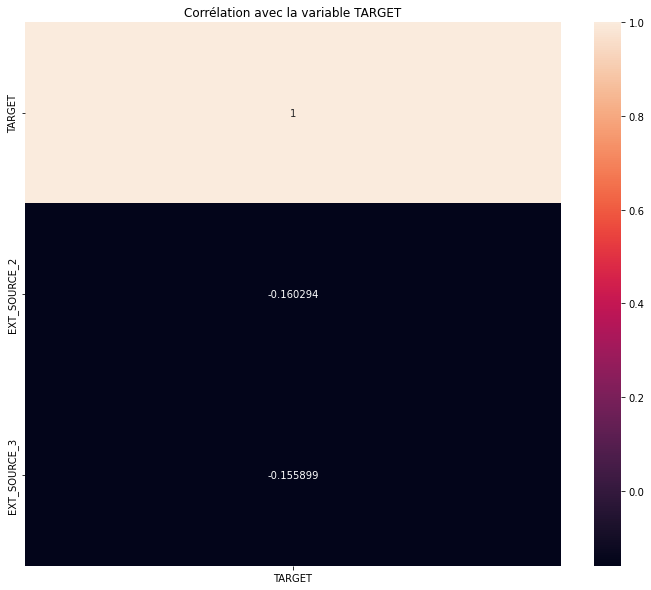

SK_ID_CURR  \
SK_ID_CURR                               1.000000   
OCCUPATION_TYPE_Private service staff   -0.000452   
OCCUPATION_TYPE_Realty agents            0.001364   
OCCUPATION_TYPE_Sales staff              0.003173   
OCCUPATION_TYPE_Secretaries              0.000652   
...                                           ...   
ACTIVE_DAYS_CREDIT_MEAN                  0.003332   
ACTIVE_DAYS_CREDIT_MAX                   0.002419   
ACTIVE_DAYS_CREDIT_MIN                   0.001446   
ACTIVE_AMT_CREDIT_SUM_MAX               -0.000701   
ACTIVE_AMT_CREDIT_SUM_MEAN              -0.000567   

                                       OCCUPATION_TYPE_Private service staff  \
SK_ID_CURR                                                         -0.000452   
OCCUPATION_TYPE_Private service staff                               1.000000   
OCCUPATION_TYPE_Realty agents                                      -0.004615   
OCCUPATION_TYPE_Sales staff                                        -0.031843   
OCCUPATION_TYPE_Secretaries                                        -0.006089   
...                                                                      ...   
ACTIVE_DAYS_CREDIT_MEAN                                             0.003314   
ACTIVE_DAYS_CREDIT_MAX                                             -0.001248   
ACTIVE_DAYS_CREDIT_MIN                                              0.006862   
ACTIVE_AMT_CREDIT_SUM_MAX                                          -0.003509   
ACTIVE_AMT_CREDIT_SUM_MEAN                                         -0.001683   

                                       OCCUPATION_TYPE_Realty agents  \
SK_ID_CURR                                                  0.001364   
OCCUPATION_TYPE_Private service staff                      -0.004615   
OCCUPATION_TYPE_Realty agents                               1.000000   
OCCUPATION_TYPE_Sales staff                                -0.016893   
OCCUPATION_TYPE_Secretaries                                -0.003230   
...                                                              ...   
ACTIVE_DAYS_CREDIT_MEAN                                     0.003637   
ACTIVE_DAYS_CREDIT_MAX                                      0.000899   
ACTIVE_DAYS_CREDIT_MIN                                      0.005388   
ACTIVE_AMT_CREDIT_SUM_MAX                                  -0.001239   
ACTIVE_AMT_CREDIT_SUM_MEAN                                 -0.000741   

                                       OCCUPATION_TYPE_Sales staff  \
SK_ID_CURR                                                0.003173   
OCCUPATION_TYPE_Private service staff                    -0.031843   
OCCUPATION_TYPE_Realty agents                            -0.016893   
OCCUPATION_TYPE_Sales staff                               1.000000   
OCCUPATION_TYPE_Secretaries                              -0.022289   
...                                                            ...   
ACTIVE_DAYS_CREDIT_MEAN                                   0.028176   
ACTIVE_DAYS_CREDIT_MAX                                    0.011524   
ACTIVE_DAYS_CREDIT_MIN                                    0.037754   
ACTIVE_AMT_CREDIT_SUM_MAX                                -0.039458   
ACTIVE_AMT_CREDIT_SUM_MEAN                               -0.034932   

                                       OCCUPATION_TYPE_Secretaries  \
SK_ID_CURR                                                0.000652   
OCCUPATION_TYPE_Private service staff                    -0.006089   
OCCUPATION_TYPE_Realty agents                            -0.003230   
OCCUPATION_TYPE_Sales staff                              -0.022289   
OCCUPATION_TYPE_Secretaries                               1.000000   
...                                                            ...   
ACTIVE_DAYS_CREDIT_MEAN                                   0.001266   
ACTIVE_DAYS_CREDIT_MAX                                    0.000293   
ACTIVE_DAYS_CREDIT_MIN                                    0.000819   
ACTIVE_AMT_CREDIT_SUM_MAX          

In [31]:
# Vérification des  correlations
df_corr=df_train.corr()


#Pour compiler plus vite le notebook
if(Lent):
    df_corr=df_train.corr()
    plt.figure(figsize=(12, 10))
    plt.title("Corrélation avec la variable TARGET")

    values=list(df_train[list(df_corr[abs(df_corr.TARGET)>=0.1].index)].corr()["TARGET"].values)

    index=list(df_train[list(df_corr[abs(df_corr.TARGET)>=0.1].index)].corr()["TARGET"].index)

 

    a = pd.DataFrame({"TARGET": values}, index=index)
    sns.heatmap(a, annot=True, fmt="g")
    plt.show()
else :
    print("...")
    
    
df_corr

In [32]:
# Distribution de la target 1/
df_train["TARGET"].value_counts(dropna=False, normalize=True)

0.0    0.91927
1.0    0.08073
Name: TARGET, dtype: float64

Risque de défaut de crédit immobilier si la target est égale à 1 sinon l'individu est en mesure de rembourser son crédit.

In [33]:
# Distribution de la target 2/
test=pd.DataFrame(df_train["TARGET"].value_counts(dropna=False, normalize=True))
# This dataframe has 244 lines, but 4 distinct values for `day`
fig = px.pie(test, values="TARGET", names=["Clients sans risques","Client avec risques"],title="Répartition du risque de défaut des clients")
fig.show()

In [34]:
#Sauvegarde des jeux de données
if(Lent):
    df_train.to_csv("df_train.csv")
    df_test.to_csv("df_test.csv")
else :
    print("...")

# <center> Modélisation </center>

Pour notre modélisation nous testerons plusieurs modèles. Pour selectionner notre modèles nous les jugerons sur essenstiellement sur l' AUC. "AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.". "The area under the ROC curve (AUC) results were considered excellent for AUC values between 0.9-1, good for AUC values between 0.8-0.9, fair for AUC values between 0.7-0.8, poor for AUC values between 0.6-0.7 and failed for AUC values between 0.5-0.6"

### Pré-processing

Pour prende en compte le déséquilibre des classes nous utiliseons l'Oversampling via SMOTE.

<img src="https://miro.medium.com/max/725/1*H6XodlitlGDl9YdbwaZLMw.png">


In [35]:
df_train.head()

SK_ID_CURR  OCCUPATION_TYPE_Private service staff  \
0      100002                                      0   
1      100003                                      0   
2      100004                                      0   
3      100006                                      0   
4      100007                                      0   

   OCCUPATION_TYPE_Realty agents  OCCUPATION_TYPE_Sales staff  \
0                              0                            0   
1                              0                            0   
2                              0                            0   
3                              0                            0   
4                              0                            0   

   OCCUPATION_TYPE_Secretaries  OCCUPATION_TYPE_Security staff  \
0                            0                               0   
1                            0                               0   
2                            0                               0   
3                            0                               0   
4                            0                               0   

   OCCUPATION_TYPE_Waiters/barmen staff  WEEKDAY_APPR_PROCESS_START_FRIDAY  \
0                                     0                                  0   
1                                     0                                  0   
2                                     0                                  0   
3                                     0                                  0   
4                                     0                                  0   

   WEEKDAY_APPR_PROCESS_START_MONDAY  WEEKDAY_APPR_PROCESS_START_SATURDAY  \
0                                  0                                    0   
1                                  1                                    0   
2                                  1                                    0   
3                                  0                                    0   
4                                  0                                    0   

   WEEKDAY_APPR_PROCESS_START_SUNDAY  WEEKDAY_APPR_PROCESS_START_THURSDAY  \
0                                  0                                    0   
1                                  0                                    0   
2                                  0                                    0   
3                                  0                                    0   
4                                  0                                    1   

   WEEKDAY_APPR_PROCESS_START_TUESDAY  OCCUPATION_TYPE_Medicine staff  \
0                                   0                               0   
1                                   0                               0   
2                                   0                               0   
3                                   0                               0   
4                                   0                               0   

   WEEKDAY_APPR_PROCESS_START_WEDNESDAY  ORGANIZATION_TYPE_Agriculture  \
0                                     1                              0   
1                                     0                              0   
2                                     0                              0   
3                                     1                              0   
4                                     0                              0   

   ORGANIZATION_TYPE_Bank  ORGANIZATION_TYPE_Business Entity Type 1  \
0                       0                                         0   
1                       0                                         0   
2                       0                                         0   
3                       0                                         0   
4                       0                                         0   

   ORGANIZATION_TYPE_Business Entity Type 2  \
0                                         0   
1                                         0   
2                              

In [36]:
# Création d'un set de validation
X = df_train.loc[:, ~df_train.columns.isin(['TARGET'])] # Features
y = df_train.TARGET # Target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

### Dummy classifier

DummyClassifier  est un classifieur qui effectue des prédictions qui ignorent les valeurs des inputs.
Il nous servira de référence simple à comparer avec d'autres classificateurs plus complexes.
Plusieurs stratégies sont possibles pour générer les prédictions, nous utiliserons la stratégie "uniform" donne une probabilité uniforme et égale  à l'apparition d'une modalité dans la target. Donc dans notre cas la probabilité d'être un individu à risque est égale à celle d'être un individu sans risque donc égale à 0.5.

In [37]:
# Modélisation Dummy
start = time.time()
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X, y)
DummyClassifier(strategy='uniform')
dummy_clf.predict(X)
end = time.time()
temps_dummy= end - start


In [38]:
#accuracy Dummy
score_dummy=dummy_clf.score(X, y)
score_dummy

0.49936749407330566

In [39]:
#AUC DUMMY
auc_dummy = metrics.roc_auc_score(y, dummy_clf.predict_proba(X)[:, 1])
auc_dummy

0.5

In [40]:
# Prédiction sur le set de validation
y_pred=dummy_clf.predict(X_test)
y_pred = pd.DataFrame(dummy_clf.predict(X_test))
y_pred=y_pred[0]>0.5

Accuracy: 0.4993983935481773
Precision: 0.07948256028476548
Recall: 0.4926678326382349


Text(0.5, 257.44, 'Predicted label')

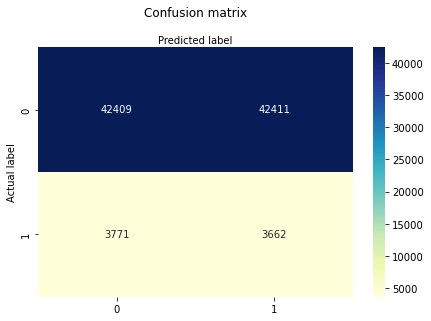

In [41]:
# Matrice de confusion
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
class_names=[0,1] # name  of classes
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [42]:
# Recall dummy
recall_dummy=metrics.recall_score(y_test, y_pred)

In [43]:
print("Le temps ecoulé :",end - start)


Le temps ecoulé : 0.040439605712890625


### Régression logistique

In [44]:
# Regreession logistique tuning
start = time.time()
model = Pipeline([
        ('scaler', StandardScaler()),
        ('sampling', SMOTE()),
        ('classification', LogisticRegression())
    ])

params = { 'classification__C':[1, 5,10], 'classification__max_iter':[100,300]}


clf = GridSearchCV(model,params, cv=3, scoring ='roc_auc')

clf.fit(X_train, y_train)
end = time.time()
temps_reg_logistique= end - start

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/anaconda3/lib/python3.8/site-packages

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [45]:
# Affichage performance
print(clf.best_params_)
print(clf.best_score_)
print(clf.n_splits_)

{'classification__C': 10, 'classification__max_iter': 300}
0.7481855491490766
3


In [46]:
#Régression logistique avec les meilleurs paramètres

logreg = Pipeline([
        ('scaler', StandardScaler()),
        ('sampling', SMOTE()),
        ('classification', LogisticRegression(C=clf.best_params_["classification__C"],max_iter=clf.best_params_["classification__max_iter"]))
    ])

logreg.fit(X_train, y_train)
y_pred=logreg.predict_proba(X_test)
y_pred = pd.DataFrame(logreg.predict_proba(X_test))
y_pred=y_pred[1]>0.5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Text(0.5, 257.44, 'Predicted label')

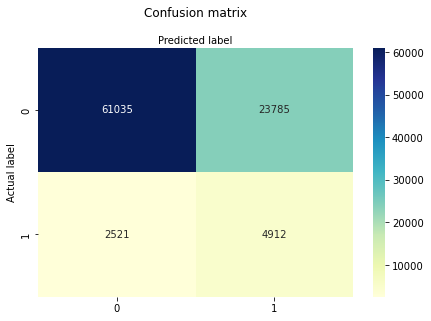

In [47]:
# Matrice de confusion
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [48]:
# Affichage performance
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
recall_logistique=metrics.recall_score(y_test, y_pred)

Accuracy: 0.7148493815919266
Precision: 0.17116771787991777
Recall: 0.6608368088255079


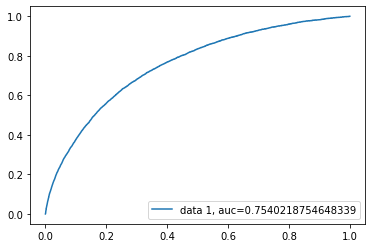

In [49]:
# Courbe ROC
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [50]:
# Score regression
score_reg_logistique=metrics.accuracy_score(y_test, y_pred)
auc_reg_logistique=metrics.roc_auc_score(y_test, y_pred_proba)

### Random Forest

In [51]:
# Random Forest tuning
start = time.time()
model = Pipeline([
        ('scaler', StandardScaler()),
        ('sampling', SMOTE()),
        ('classification', RandomForestClassifier())
    ])

params = {'classification__n_estimators':[10,100], 'classification__max_depth':[5,15]}

clf = GridSearchCV(model,params, cv=3, scoring ='roc_auc')

clf.fit(X_train, y_train)
end = time.time()
temps_randomforest= end - start

In [52]:
# Meilleur paramètres
print(clf.best_params_)
print(clf.best_score_)

{'classification__max_depth': 15, 'classification__n_estimators': 100}
0.6967858426816157


In [53]:
# Random Forest avec meilleur paramètres
Randomforest = Pipeline([
        ('scaler', StandardScaler()),
        ('sampling', SMOTE()),
        ('classification', RandomForestClassifier(n_estimators=clf.best_params_['classification__n_estimators'] ,max_depth=clf.best_params_["classification__max_depth"]))
    ])

Randomforest.fit(X_train, y_train)
y_pred=Randomforest.predict_proba(X_test)
y_pred = pd.DataFrame(Randomforest.predict_proba(X_test))
y_pred=y_pred[1]>0.5

Accuracy: 0.8976835441665854
Precision: 0.24002073613271124
Recall: 0.12457957755953182


Text(0.5, 257.44, 'Predicted label')

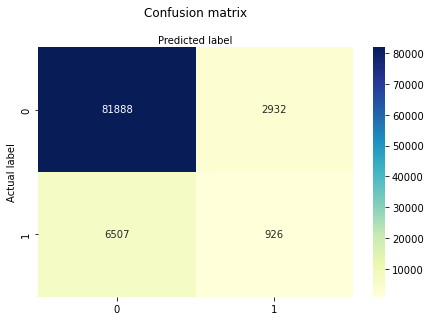

In [54]:
# Matrice de confusion
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [55]:
#  Perdotmance
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
recall_randomforest=metrics.recall_score(y_test, y_pred)

Accuracy: 0.8976835441665854
Precision: 0.24002073613271124
Recall: 0.12457957755953182


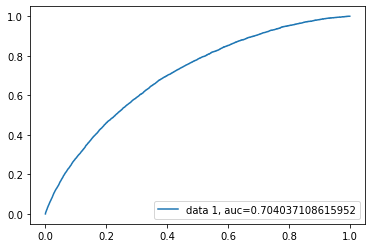

In [56]:
# Couurbe ROC
y_pred_proba = Randomforest.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [57]:
# Score Random Forest
score_randomforest=metrics.accuracy_score(y_test, y_pred)
auc_randomforest=metrics.roc_auc_score(y_test, y_pred_proba)

### Comparaison des modèles

In [58]:
#Performance modèles

liste_accuracy=[ score_dummy, score_reg_logistique,score_randomforest]
liste_AUC=[ auc_dummy,auc_reg_logistique,auc_randomforest]
liste_recall=[recall_dummy,recall_logistique,recall_randomforest]


fig = go.Figure(data=go.Scatter(
    x=["Regression dummy","Regression logistique","Random forest"],
    y=liste_accuracy,
    mode='markers',
    name="Accuracy"
))

fig.add_trace(go.Scatter(
   x=["Regression dummy","Regression logistique","Random forest"], y=liste_AUC,name="AUC",marker_color='rgba(255, 182, 193, .9)',
    mode='markers'
))

fig.add_trace(go.Scatter(
   x=["Regression dummy","Regression logistique","Random forest"], y=liste_recall,name="Recall",marker_color='rgba(255, 102, 103, .9)',
    mode='markers'
))

fig.update_traces(marker=dict(size=12,
                              line=dict(width=22,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))


fig.update_layout(
    title="Comparaison de la performance des modèles",
    xaxis_title="Modèles")

fig.show()

In [59]:
# Temps modèles

fig = go.Figure(data=go.Scatter(
    x=["Regression dummy","Regression logistique","Random forest"],
    y=[temps_dummy, temps_reg_logistique, temps_randomforest],
    mode='markers',
    name="R2"
))



fig.update_traces(marker=dict(size=12,
                              line=dict(width=22,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))


fig.update_layout(
    title="Comparaison du temps des modèles",
    xaxis_title="Modèles")

fig.show()

### Selection du meilleur modèle

La fonction coût avec l'AUC n'est pas la plus optimisée pour notre problématique, nous utilisrons plutot fbetascore pour améliorer le recall.

In [60]:
#Fonction de coût métier – optimisation du modèle 
#modele avec fbetascore

ftwo_scorer = make_scorer(fbeta_score, beta=10)


In [61]:
# Tuning avec fbeta logreg
ftwo_scorer = make_scorer(fbeta_score, beta=10)

start = time.time()
model = Pipeline([
        ('scaler', StandardScaler()),
        ('sampling', SMOTE()),
        ('classification', LogisticRegression())
    ])

params = { 'classification__C':[1,5,10,16], 'classification__max_iter':[100,300,400]}


clf = GridSearchCV(model,params, cv=3, scoring =ftwo_scorer)

clf.fit(X_train, y_train)
end = time.time()
temps_logreg_ajuste= end - start

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/anaconda3/lib/python3.8/site-packages

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/anaconda3/lib/python3.8/site-packages

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [62]:
# Meilleurs paramètres
print(clf.best_params_)
print(clf.best_score_)

{'classification__C': 16, 'classification__max_iter': 400}
0.628499590959085


In [63]:
# Random Forest avec les meilleurs paramètres
logreg = Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('sampling', SMOTE()),
        ('classification', LogisticRegression(C=clf.best_params_["classification__C"],max_iter=clf.best_params_["classification__max_iter"]))
    ])

logreg.fit(X_train, y_train)
y_pred=logreg.predict_proba(X_test)
y_pred = pd.DataFrame(logreg.predict_proba(X_test))
y_pred_proba=y_pred 
y_pred=y_pred[1]>0.3

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy: 0.5037234561477676
Precision: 0.12381307384446363
Recall: 0.8490515269743037


Text(0.5, 257.44, 'Predicted label')

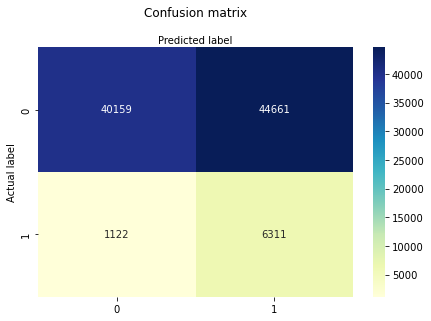

In [64]:
# Matrice de confusion
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [65]:
# Affichage performance
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
recall_logreg_ajuste=metrics.recall_score(y_test, y_pred)

Accuracy: 0.5037234561477676
Precision: 0.12381307384446363
Recall: 0.8490515269743037


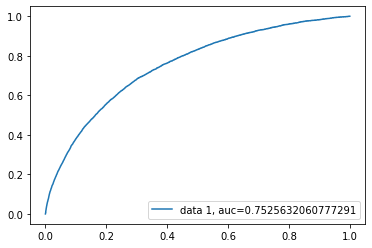

In [66]:
# Courbe ROC
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [67]:
# Score logreg
score_logreg_ajuste=metrics.accuracy_score(y_test, y_pred)
auc_logreg_ajuste=metrics.roc_auc_score(y_test, y_pred_proba)

In [68]:
#Performance modèles comparaison mise à jour

liste_accuracy=[ score_dummy, score_reg_logistique,score_randomforest,score_logreg_ajuste]
liste_AUC=[ auc_dummy,auc_reg_logistique,auc_randomforest,auc_logreg_ajuste]
liste_recall=[recall_dummy,recall_logistique,recall_randomforest,recall_logreg_ajuste]


fig = go.Figure(data=go.Scatter(
    x=["Regression dummy","Regression logistique","Random forest","Regression logistique ajusté"],
    y=liste_accuracy,
    mode='markers',
    name="Accuracy"
))

fig.add_trace(go.Scatter(
   x=["Regression dummy","Regression logistique","Random forest","Regression logistique ajusté"], y=liste_AUC,name="AUC",marker_color='rgba(255, 182, 193, .9)',
    mode='markers'
))

fig.add_trace(go.Scatter(
   x=["Regression dummy","Regression logistique","Random forest","Regression logistique ajusté"], y=liste_recall,name="Recall",marker_color='rgba(255, 102, 103, .9)',
    mode='markers'
))

fig.update_traces(marker=dict(size=12,
                              line=dict(width=22,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))


fig.update_layout(
    title="Comparaison de la performance des modèles",
    xaxis_title="Modèles")

fig.show()

In [69]:
# Temps modèles mis à jour
fig = go.Figure(data=go.Scatter(
    x=["Regression dummy","Regression logistique","Random forest","Regression logistique ajusté"],
    y=[temps_dummy, temps_reg_logistique, temps_randomforest, temps_logreg_ajuste],
    mode='markers',
    name="R2"
))



fig.update_traces(marker=dict(size=12,
                              line=dict(width=22,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))


fig.update_layout(
    title="Comparaison du temps des modèles",
    xaxis_title="Modèles")

fig.show()

In [70]:
# Features importances du modele

b=list(logreg[2].coef_[0])
a=list(X_test.columns)
df_features_importance={'Nom_colonne':a,'Coeff':b}

df_features_importance=pd.DataFrame(df_features_importance)

table_positif=df_features_importance.sort_values(by="Coeff",ascending=False)[:10]

fig = go.Figure(go.Bar(
            x=table_positif.Coeff.values,
            y=table_positif.Nom_colonne.values,
            orientation='h'))

fig.update_layout(title_text='Variables augmentant le risque de défaut', title_x=0.5)

fig.show()

In [71]:
# Features importances du modele

b=list(logreg[2].coef_[0])
a=list(X_test.columns)
df_features_importance={'Nom_colonne':a,'Coeff':b}

df_features_importance=pd.DataFrame(df_features_importance)

table_negatif=df_features_importance.sort_values(by="Coeff",ascending=True)[:10]
fig = go.Figure(go.Bar(
            marker=dict(color='red'),
            x=table_negatif.Coeff.values,
            y=table_negatif.Nom_colonne.values,
            orientation='h'))
fig.update_layout(title_text='Variables réduisant le risque de défaut', title_x=0.5)
fig.show()

In [72]:
#X_train.head(20)
#logreg.predict_proba(X_train.head(20))
# Feature locale shap
explainer = shap.KernelExplainer(logreg.predict_proba,shap.kmeans(X_train,3))
choosen_instance = X_test.loc[14]
shap_values = explainer.shap_values(choosen_instance)
print(explainer.expected_value)
#print(choosen_instance)
#print(shap_values)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)


# Feature locale shap Randomforest
#explainer = shap.TreeExplainer(Randomforest[2],X_train)
#choosen_instance = X_train.loc[3]
#shap_values = explainer.shap_values(choosen_instance)
#shap.initjs()
#shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a f

[0.55012661 0.44987339]


In [73]:
explainer = shap.KernelExplainer(logreg.predict_proba,shap.kmeans(X_train,3))
shap_values=explainer.shap_values(X_train.head(10))


/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



  0%|          | 0/10 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set paramet

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set paramet

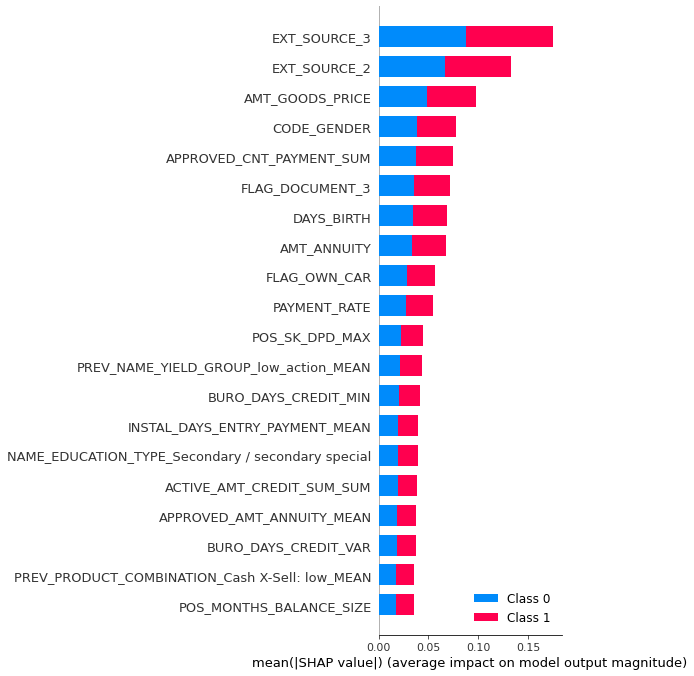

In [74]:
shap.summary_plot(shap_values, features=X_train, plot_type='bar')

In [75]:
# Feature globale shap
#choosen_instance = X_train
#shap_values = explainer.shap_values(choosen_instance)
#shap.summary_plot(shap_values, X_train, plot_size=[8,6])

# <center> FIN </center>

In [86]:
#Exportation du modèle
# save the model to disk
filename = 'model.sav'
pickle.dump(logreg, open(filename, 'wb'))

In [77]:
# Test export

loaded_model = pickle.load(open(filename, 'rb'))
explainer = shap.KernelExplainer(loaded_model.predict_proba,shap.kmeans(X_train,3))
choosen_instance = X_test.loc[14]
shap_values = explainer.shap_values(choosen_instance)
#print(explainer.expected_value)
#print(choosen_instance)
#print(shap_values)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a f

In [78]:
#Sauvegarde deu jeux de validation
Lent=1
if(Lent):
    #X_test
    #df_Xvalidation=X_test.reset_index()
    #df_Xvalidation["Score"]=y_pred
    #df_Xvalidation["Score_proba"]=y_pred_proba
    df_Xvalidation=X_test
    df_Xvalidation.to_csv("df_Xvalidation.csv")
    #X_train
    #df_Xtrain=X_train.reset_index()
    df_Xtrain=X_train
    df_Xtrain.to_csv("df_Xtrain.csv")
else :
    print("...")

In [79]:
#if(Lent):
    #X_test["Score_proba"].head()

In [80]:
#if(Lent):
    #X_test["Score"].head()

In [81]:
df_Xvalidation

SK_ID_CURR  OCCUPATION_TYPE_Private service staff  \
289126      434951                                      0   
188491      318534                                      0   
181177      309972                                      0   
247950      386913                                      0   
231639      368305                                      0   
...            ...                                    ...   
287907      433522                                      0   
125584      245632                                      0   
51502       159637                                      0   
276439      420342                                      0   
115235      233631                                      0   

        OCCUPATION_TYPE_Realty agents  OCCUPATION_TYPE_Sales staff  \
289126                              0                            0   
188491                              0                            0   
181177                              0                            0   
247950                              0                            0   
231639                              0                            0   
...                               ...                          ...   
287907                              0                            0   
125584                              0                            0   
51502                               0                            0   
276439                              0                            1   
115235                              0                            0   

        OCCUPATION_TYPE_Secretaries  OCCUPATION_TYPE_Security staff  \
289126                            0                               0   
188491                            0                               0   
181177                            0                               0   
247950                            0                               0   
231639                            0                               0   
...                             ...                             ...   
287907                            0                               0   
125584                            0                               0   
51502                             0                               0   
276439                            0                               0   
115235                            0                               0   

        OCCUPATION_TYPE_Waiters/barmen staff  \
289126                                     0   
188491                                     0   
181177                                     0   
247950                                     0   
231639                                     0   
...                                      ...   
287907                                     0   
125584                                     0   
51502                                      0   
276439                                     0   
115235                                     0   

        WEEKDAY_APPR_PROCESS_START_FRIDAY  WEEKDAY_APPR_PROCESS_START_MONDAY  \
289126                                  0                                  0   
188491                                  0                                  1   
181177                                  0                                  0   
247950                                  0                                  1   
231639                                  1                                  0   
...                                   ...                                ...   
287907                                  0                                  0   
125584                                  0                                  0   
51502                                   0                                  0   
276439                                  0                                  0   
115235                                  0                                  0   

        WEEKDAY_APPR_PROCESS_START_SATURDAY

In [82]:
df_Xtrain

SK_ID_CURR  OCCUPATION_TYPE_Private service staff  \
113008      231070                                      0   
132495      253674                                      0   
18531       121615                                      0   
234353      371466                                      0   
156995      281971                                      0   
...            ...                                    ...   
122582      242117                                      0   
304141      452378                                      0   
152318      276548                                      0   
117955      236779                                      0   
305715      454203                                      0   

        OCCUPATION_TYPE_Realty agents  OCCUPATION_TYPE_Sales staff  \
113008                              0                            0   
132495                              0                            0   
18531                               0                            0   
234353                              0                            0   
156995                              0                            0   
...                               ...                          ...   
122582                              0                            0   
304141                              0                            0   
152318                              0                            0   
117955                              0                            0   
305715                              0                            0   

        OCCUPATION_TYPE_Secretaries  OCCUPATION_TYPE_Security staff  \
113008                            0                               0   
132495                            0                               0   
18531                             0                               0   
234353                            0                               0   
156995                            0                               0   
...                             ...                             ...   
122582                            0                               0   
304141                            0                               0   
152318                            0                               0   
117955                            0                               0   
305715                            0                               0   

        OCCUPATION_TYPE_Waiters/barmen staff  \
113008                                     0   
132495                                     0   
18531                                      0   
234353                                     0   
156995                                     0   
...                                      ...   
122582                                     0   
304141                                     0   
152318                                     0   
117955                                     0   
305715                                     0   

        WEEKDAY_APPR_PROCESS_START_FRIDAY  WEEKDAY_APPR_PROCESS_START_MONDAY  \
113008                                  0                                  0   
132495                                  1                                  0   
18531                                   0                                  0   
234353                                  0                                  0   
156995                                  0                                  0   
...                                   ...                                ...   
122582                                  0                                  0   
304141                                  0                                  0   
152318                                  0                                  0   
117955                                  0                                  0   
305715                                  0                                  0   

        WEEKDAY_APPR_PROCESS_START_SATURDAY

In [83]:
logreg

Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('sampling', SMOTE()),
                ('classification', LogisticRegression(C=16, max_iter=400))])

In [84]:
X_train

SK_ID_CURR  OCCUPATION_TYPE_Private service staff  \
113008      231070                                      0   
132495      253674                                      0   
18531       121615                                      0   
234353      371466                                      0   
156995      281971                                      0   
...            ...                                    ...   
122582      242117                                      0   
304141      452378                                      0   
152318      276548                                      0   
117955      236779                                      0   
305715      454203                                      0   

        OCCUPATION_TYPE_Realty agents  OCCUPATION_TYPE_Sales staff  \
113008                              0                            0   
132495                              0                            0   
18531                               0                            0   
234353                              0                            0   
156995                              0                            0   
...                               ...                          ...   
122582                              0                            0   
304141                              0                            0   
152318                              0                            0   
117955                              0                            0   
305715                              0                            0   

        OCCUPATION_TYPE_Secretaries  OCCUPATION_TYPE_Security staff  \
113008                            0                               0   
132495                            0                               0   
18531                             0                               0   
234353                            0                               0   
156995                            0                               0   
...                             ...                             ...   
122582                            0                               0   
304141                            0                               0   
152318                            0                               0   
117955                            0                               0   
305715                            0                               0   

        OCCUPATION_TYPE_Waiters/barmen staff  \
113008                                     0   
132495                                     0   
18531                                      0   
234353                                     0   
156995                                     0   
...                                      ...   
122582                                     0   
304141                                     0   
152318                                     0   
117955                                     0   
305715                                     0   

        WEEKDAY_APPR_PROCESS_START_FRIDAY  WEEKDAY_APPR_PROCESS_START_MONDAY  \
113008                                  0                                  0   
132495                                  1                                  0   
18531                                   0                                  0   
234353                                  0                                  0   
156995                                  0                                  0   
...                                   ...                                ...   
122582                                  0                                  0   
304141                                  0                                  0   
152318                                  0                                  0   
117955                                  0                                  0   
305715                                  0                                  0   

        WEEKDAY_APPR_PROCESS_START_SATURDAY

In [85]:
len(logreg[2].coef_[0])

543